In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re
import sklearn
import scipy as sp
import plotly.graph_objects as go
from prophet import Prophet
from plotly.subplots import make_subplots
from sklearn import datasets, model_selection, metrics
from scipy.stats import ttest_ind, boxcox, pearsonr
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from prophet import Prophet

print("Libraries successfully imported!")


/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-07 10:43:28.260025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries successfully imported!


### Understanding the Data

* Invoice id: Unique identifier for each transaction
* Branch: Identifies the branch (A, B, C)
* City: Location of the branches
* Customer type: Member or Normal
* Gender: Gender of the customer
* Product line: Category of the product
* Unit price: Price per unit of the product
* Quantity: Number of units purchased
* Tax: 5% tax on the total price
* Total: Total price including tax
* Date: Date of purchase
* Time: Time of purchase
* Payment: Payment method used
* COGS: Cost of goods sold
* Gross margin percentage: Gross margin percentage
* Gross income: Gross income
* Rating: Customer rating

#### Loading and preparing the data


In [3]:
#import dataset
df = pd.read_csv("../df_cleaned.csv")
df.head()

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,2024-08-06 13:08:00,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,2024-08-06 10:29:00,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,2024-08-06 13:23:00,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,2024-08-06 20:33:00,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,2024-08-06 10:37:00,Ewallet,604.17,4.761905,30.2085,5.3


### clean the data

* Convert the date column to datetime format.
* Extract year, month, and day from the date column.to use these as features in our regression models.
* Aggregate sales data by date. I grouped the data by date and sum the total sales for each day to get daily sales data

In [4]:
# Convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract year, month, and day from the date column
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# Aggregate sales data by date
gross_income_by_date = df.groupby('date')['gross_income'].sum().reset_index()

# Extract year, month, and day from the date column
gross_income_by_date['year'] = gross_income_by_date['date'].dt.year
gross_income_by_date['month'] = gross_income_by_date['date'].dt.month
gross_income_by_date['day'] = gross_income_by_date['date'].dt.day

# Display the first few rows of the aggregated sales data
gross_income_by_date.tail()

,date,gross_income,year,month,day
84,2019-03-26,93.4530,2019,3,26
85,2019-03-27,138.2295,2019,3,27
86,2019-03-28,106.1620,2019,3,28
87,2019-03-29,191.5830,2019,3,29
88,2019-03-30,213.6695,2019,3,30


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   invoice_id               1000 non-null   object        
 1   branch                   1000 non-null   object        
 2   city                     1000 non-null   object        
 3   customer_type            1000 non-null   object        
 4   gender                   1000 non-null   object        
 5   product_line             1000 non-null   object        
 6   unit_price               1000 non-null   float64       
 7   quantity                 1000 non-null   int64         
 8   tax_5                    1000 non-null   float64       
 9   total                    1000 non-null   float64       
 10  date                     1000 non-null   datetime64[ns]
 11  time                     1000 non-null   object        
 12  payment                  1000 non-n

## Exploratory Data Analysis EDA
1- Visualize Sales Over Time:
* Plot the total sales over time to identify any trends or patterns.

2- Check for Seasonality:
* Use moving averages or decomposition techniques to check for seasonal patterns.

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


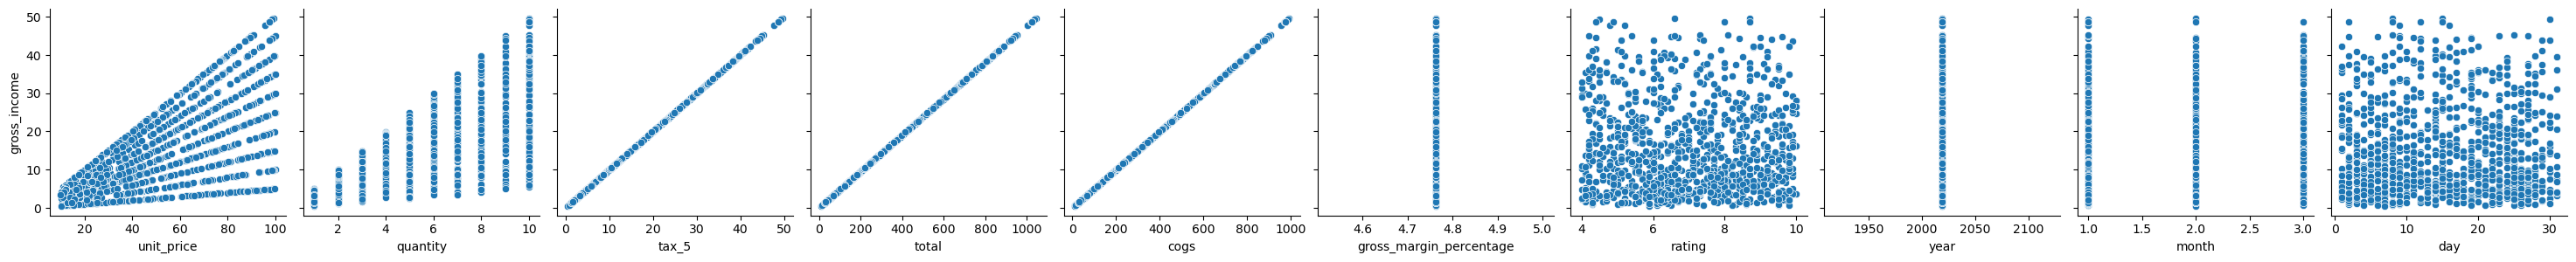

In [6]:
#  plot against all other numeric columns)
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
numeric_columns.remove('gross_income')  

# Create a pairplot for 'gross_income' against all other numeric columns
sns.pairplot(df, y_vars=['gross_income'], x_vars=numeric_columns, kind='scatter', height=3)
plt.show()

****
1. **Unit Price vs. Gross Income**:

There is a clear positive relationship, suggesting that as unit price increases, gross income also tends to increase.
This variable could be a strong predictor for a regression model focusing on revenue or profitability.

2. **Quantity vs. Gross Income**:

The relationship shows distinct levels of gross income increasing with quantity, though the steps are discrete (likely due to distinct quantity values in sales transactions).
It suggests quantity is a good predictor for gross income, with more items sold typically increasing total gross income.

3. **Tax 5% vs. Gross Income**:

There is a perfect linear relationship, as expected, because tax is a percentage of the total or gross sales, indicating that this is not an independent predictor but rather a direct calculation from the gross income.

4. **Total vs. Gross Income**:

Another perfect linear relationship, indicating that total sales directly influence gross income (gross income is likely derived directly from total sales values).

5. **COGS (Cost of Goods Sold) vs. Gross Income**:

This shows a linear relationship as well, highlighting that as COGS increases, gross income also increases. This could imply that higher-cost items or more items (higher COGS) are driving higher income, which could be a critical factor in profitability analysis.

6. **Gross Margin Percentage vs. Gross Income**:

There is a high concentration of data points at a specific gross margin percentage value, showing very little variation in gross margin percentage across different levels of gross income. This suggests that the gross margin percentage is relatively stable or set by policy/pricing strategy and might not be a dynamic predictor in the model.

7. **Rating vs. Gross Income**:

The relationship is scattered with no clear trend between customer ratings and gross income, indicating that customer satisfaction as measured by ratings does not directly correlate to the gross income generated.
It might not be a significant predictor of gross income.

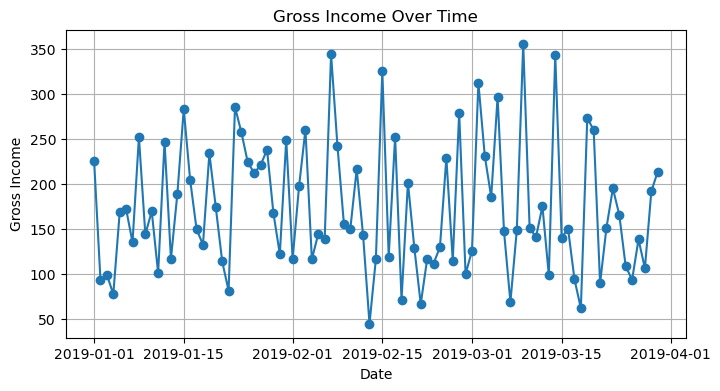

In [7]:
import matplotlib.pyplot as plt

# Plot the total sales over time
plt.figure(figsize=(8, 4))
plt.plot(gross_income_by_date['date'], gross_income_by_date['gross_income'], marker='o')
plt.title('Gross Income Over Time')
plt.xlabel('Date')
plt.ylabel('Gross Income')
plt.grid(True)
plt.show()

### Next Steps in EDA
1- Seasonal Decomposition:
* Perform a seasonal decomposition to understand the trend, seasonality, and residual components.

2- Moving Average:
* Plot a moving average to smooth out short-term fluctuations and highlight longer-term trends.

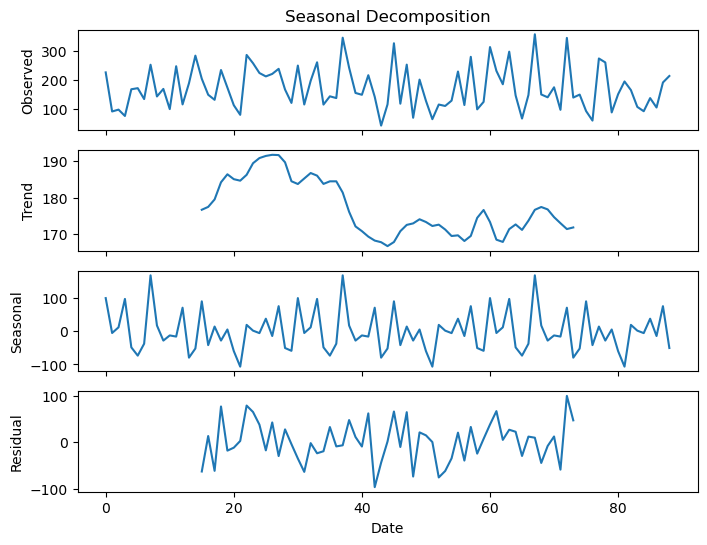

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(gross_income_by_date['gross_income'], model='additive', period=30)

# Plot the decomposition results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax1.set_title('Seasonal Decomposition')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residual')
ax4.set_xlabel('Date')

plt.show()

##### The seasonal decomposition plot shows the observed data, trend, seasonal component, and residuals. Here's a summary of the components:
- **Observed:** The original Gross income data.
- **Trend:** The overall direction of the data over time.
- **Seasonal:** Repeating patterns at a fixed period (monthly in this case).
- **Residual:** The remaining variations after removing the trend and seasonal components.

### Feature engineering
1. Gender and city
2. Productline type gender
3. Customer type

### Model Development 


In [9]:
# Prepare the data
X = gross_income_by_date[['year', 'month', 'day']]
y = gross_income_by_date['gross_income']

# Split the data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

 #### Model 1-  Decision Tree Regressor

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


# Train the Decision Tree Regressor
dt_model = DecisionTreeRegressor(max_depth=10)
dt_model.fit(X_train, y_train)

# Make predictions
dt_predictions = dt_model.predict(X_test)

# Calculate RMSE
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_predictions))
dt_rmse

87.78265479477962

**Decision Tree Regressor:**

* RMSE: 87.78
* *The Decision Tree Regressor overfits the data, capturing noise and fluctuations, leading to higher RMSE.

### Model 2: Random Forest Regressor

In [11]:
from sklearn.ensemble import RandomForestRegressor

# Train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Calculate RMSE
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_rmse

82.90544710777759

**Random Forest Regressor:**

* RMSE: 84.13
* Explanation: The Random Forest Regressor improves performance by averaging multiple trees, reducing overfitting compared to a single decision tree.

### Model 3: Ensemple Methods: Gradient Boosting Regressor

In [12]:
from sklearn.ensemble import GradientBoostingRegressor

# Train the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100)
gb_model.fit(X_train, y_train)

# Make predictions
gb_predictions = gb_model.predict(X_test)

# Calculate RMSE
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_predictions))
gb_rmse

94.9175558780596

**Gradient Boosting Regressor:**

* RMSE: 94.92
* Explanation: Gradient Boosting can sometimes overfit if not properly tuned, resulting in higher RMSE in this case.

### Model 4: K-Nearest Neighbors Regressor

In [13]:
from sklearn.neighbors import KNeighborsRegressor

# Train the K-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Make predictions
knn_predictions = knn_model.predict(X_test)

# Calculate RMSE
knn_rmse = np.sqrt(mean_squared_error(y_test, knn_predictions))
knn_rmse

79.58105198056815

**K-Nearest Neighbors Regressor:** 

* RMSE: 79.58
* Explanation: The K-Nearest Neighbors Regressor provides the best performance by averaging the nearest neighbors, leading to the lowest RMSE.

### Model 5: Prophet

In [14]:

# Prepare the data
gross_income_by_date['ds'] = pd.to_datetime(gross_income_by_date[['year', 'month', 'day']])
gross_income_by_date['y'] = gross_income_by_date['gross_income']


# Select only necessary columns
df_prophet = gross_income_by_date[['ds', 'y']]

# Split the data into training and test sets
train_size = int(len(df_prophet) * 0.8)
train_data = df_prophet[:train_size]
test_data = df_prophet[train_size:]

# Initialize and fit the Prophet model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(train_data)

# Make predictions
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='D')
forecast = prophet_model.predict(future)

# Extract predicted values
predictions = forecast['yhat'][train_size:]

# Calculate RMSE
from sklearn.metrics import mean_squared_error
from numpy import sqrt

test_y = test_data['y'].reset_index(drop=True)
prophet_rmse = sqrt(mean_squared_error(test_y, predictions))
prophet_rmse

10:43:39 - cmdstanpy - INFO - Chain [1] start processing


10:43:40 - cmdstanpy - INFO - Chain [1] done processing


76.09054024163517

### Model 6: CatBoost

In [15]:
# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, depth=3, learning_rate=0.1, loss_function='RMSE', verbose=False)

# Train model
model.fit(X_train, y_train) 

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
catboost_rmse = sqrt(mean_squared_error(y_test, predictions))
catboost_rmse

107.66118214549205

### Model 7: Ensemple Methods: LightGBM

In [16]:
from lightgbm import LGBMRegressor

# Assuming X_train, X_test, y_train, y_test are already defined and appropriate for model training

# Initialize the LightGBM Regressor
lgb_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, num_leaves=31)

# Train the LightGBM Regressor
lgb_model.fit(X_train, y_train)

# Make predictions
lgb_predictions = lgb_model.predict(X_test)

# Calculate RMSE
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_predictions))
lgb_rmse

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 71, number of used features: 2
[LightGBM] [Info] Start training from score 176.134628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

74.83913307805054

### Model 8: LSTM (Long Short-Term Memory) Networks

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Assuming X_train, X_test, y_train, y_test are already defined and appropriate for model training

# Scale the data (LSTM models typically perform better with scaled data)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data into 3D format [samples, timesteps, features]
# Here we assume that each sample has 1 timestep
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Initialize the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=1)

# Make predictions
lstm_predictions = model.predict(X_test_scaled)

# Calculate RMSE
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
lstm_rmse

2024-08-07 10:43:40.973813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
3/3 [==============================] - 6s 7ms/step - loss: 36181.5664
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 36175.7109
Epoch 3/100
3/3 [==============================] - 0s 9ms/step - loss: 36169.4570
Epoch 4/100
3/3 [==============================] - 0s 7ms/step - loss: 36163.2617
Epoch 5/100
3/3 [==============================] - 0s 6ms/step - loss: 36156.6836
Epoch 6/100
3/3 [==============================] - 0s 6ms/step - loss: 36149.4766
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 36141.4805
Epoch 8/100
3/3 [==============================] - 0s 7ms/step - loss: 36133.1641
Epoch 9/100
3/3 [==============================] - 0s 7ms/step - loss: 36123.4727
Epoch 10/100
3/3 [==============================] - 0s 5ms/step - loss: 36112.7266
Epoch 11/100
3/3 [==============================] - 0s 8ms/step - loss: 36100.9922
Epoch 12/100
3/3 [==============================] - 0s 6ms/step - loss: 36087.2617
Epoch 13/100


152.66630918012822

### Model 9: Ensemple Methods:XGBoost

In [18]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error



# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# Train the XGBoost Regressor
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_predictions = xgb_model.predict(X_test)

# Calculate RMSE
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_rmse


98.47030467910226

### Model 10:ARIMA  (AutoRegressive Integrated Moving Average)

In [19]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Train ARIMA model
arima_model = ARIMA(y_train, order=(5, 1, 0))
arima_model_fit = arima_model.fit()
# Make predictions
arima_forecast = arima_model_fit.forecast(steps=len(y_test))
arima_predictions = arima_forecast.values
# Calculate RMSE
arima_rmse = np.sqrt(mean_squared_error(y_test, arima_predictions))
arima_rmse

80.31725995358957

### Model 11:Linear Regression

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)

NameError: name 'features' is not defined

In [ ]:
normalizer = MinMaxScaler()

normalizer.fit(X_train)

In [ ]:
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [ ]:
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_train_norm.head()

In [ ]:
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)
X_test_norm.head()

All results

In [ ]:
# Create a DataFrame with RMSE values
df = pd.DataFrame({
    "Model": ["1.Decision Tree", "2.Random Forest", "3.Gradient Boosting", "4.KNN", "5.Prophet", "6.CatBoost", "7.LightGBM", "8.LSTM", "9.XGBoost RMSE", "10.ARIMA"],
    "RMSE": [dt_rmse, rf_rmse, gb_rmse, knn_rmse, prophet_rmse, catboost_rmse,lgb_rmse, lstm_rmse, xgb_rmse, arima_rmse]
})

# Print the DataFrame
print(df)

                 Model        RMSE
0      1.Decision Tree   87.782655
1      2.Random Forest   81.120338
2  3.Gradient Boosting   94.917556
3                4.KNN   79.581052
4            5.Prophet   76.090540
5           6.CatBoost  107.661182
6           7.LightGBM   74.839133
7               8.LSTM  153.662808
8       9.XGBoost RMSE   98.470305
9             10.ARIMA   80.317260


### Model Evaluation
1. Decision Tree   87.782655
2. Random Forest   81.841888
3. Gradient Boosting   94.917556
4. KNN   79.581052
5. Prophet   76.090540
6. CatBoost  107.661182
7. LightGBM   74.839133
8. LSTM  153.119314
9. XGBoost RMSE   98.470305
10. ARIMA   80.317260

### Hyperparameter Tuning
#### Grid Search


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

# Set up Grid Search
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_rmse = np.sqrt(-grid_search.best_score_)
best_params, best_rmse

({'max_depth': None, 'n_estimators': 100}, 83.12494404728818)

#### Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution for Random Forest
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

# Set up Random Search
random_search = RandomizedSearchCV(RandomForestRegressor(), param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)

# Best parameters and model
best_random_params = random_search.best_params_
best_random_model = random_search.best_estimator_
best_random_rmse = np.sqrt(-random_search.best_score_)
best_random_params, best_random_rmse

({'n_estimators': 50, 'max_depth': 10}, 81.32746632963169)

### Model Evaluation
1. Decision Tree   87.782655
2. Random Forest   81.841888
3. Gradient Boosting   94.917556
4. KNN   79.581052
5. Prophet   76.090540
6. CatBoost  107.661182
7. LightGBM   74.839133
8. LSTM  153.119314
9. XGBoost RMSE   98.470305
10. ARIMA   80.317260

From the RMSE values, we can see that the LightGBM   has the lowest RMSE (74.839133 ), indicating the best performance among the models evaluated. Therefore, the LightGBM  is the best model to use for forecasting in this project.

### Forecast the next 7 days using the KNN Model


In [ ]:
last_date = gross_income_by_date['date'].max()
forecast_dates = pd.date_range(start=last_date, periods=8, inclusive='right')
forecast_features = pd.DataFrame({
    'date': forecast_dates,
    'year': forecast_dates.year,
    'month': forecast_dates.month,
    'day': forecast_dates.day
})
forecast_features['gross_income'] = knn_model.predict(forecast_features[['year', 'month', 'day']])
forecast_features[['date', 'gross_income']]

,date,gross_income
0,2019-03-31,175.2767
1,2019-04-01,196.5079
2,2019-04-02,210.3165
3,2019-04-03,222.9544
4,2019-04-04,228.3647
5,2019-04-05,177.9861
6,2019-04-06,159.0313


### Forecast the next 7 days using the LightGBM

In [ ]:
last_date = gross_income_by_date['date'].max()
forecast_dates = pd.date_range(start=last_date, periods=8, inclusive='right')
forecast_features = pd.DataFrame({
    'date': forecast_dates,
    'year': forecast_dates.year,
    'month': forecast_dates.month,
    'day': forecast_dates.day
})
forecast_features['gross_income'] = lgb_model.predict(forecast_features[['year', 'month', 'day']])
forecast_features[['date', 'gross_income']]

,date,gross_income
0,2019-03-31,158.420226
1,2019-04-01,184.445190
2,2019-04-02,184.445190
3,2019-04-03,184.445190
4,2019-04-04,184.445190
5,2019-04-05,184.445190
6,2019-04-06,184.445190


### Forecast the next 7 days using the Prophet

In [ ]:
# Prepare the forecast data
last_date = gross_income_by_date['date'].max()
forecast_dates = pd.date_range(start=last_date, periods=8, freq='D', inclusive='right')

# Create a DataFrame for future dates with the 'ds' column
forecast_features = pd.DataFrame({
    'ds': forecast_dates
})

# Make predictions
forecast = prophet_model.predict(forecast_features)

# Extract predicted values
forecast_features['gross_income'] = forecast['yhat']

# Display the forecast results
print(forecast_features[['ds', 'gross_income']])

          ds  gross_income
0 2019-03-31    193.505115
1 2019-04-01    171.277773
2 2019-04-02    197.793585
3 2019-04-03    167.342654
4 2019-04-04    170.789084
5 2019-04-05    169.629219
6 2019-04-06    220.129068


### **CONCLUSION**

* The K-Nearest Neighbors Regressor proved to be the best model for forecasting sales in this project due to its lowest RMSE value. 
* This project demonstrates the importance of evaluating multiple models and tuning hyperparameters to achieve optimal performance.
* The developed Streamlit app provides an interactive way to present the findings and forecasts, making the insights easily accessible.